In [45]:
import os
import cv2
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [46]:
# Configuration
VIDEO_DIR = "fortnite_videos"  # Directory containing the downloaded videos
FRAMES_DIR = "character_frames"  # Directory to save extracted frames
FRAMES_PER_ROTATION = 8  # Number of frames to extract per video (360 for full rotation)

# Create output directory
os.makedirs(FRAMES_DIR, exist_ok=True)

In [47]:
def extract_frames_from_video(video_path, num_frames=360):
    """
    Extract evenly spaced frames from a video
    
    Args:
        video_path: Path to the video file
        num_frames: Number of frames to extract (default 360 for full rotation)
    
    Returns:
        List of frames (numpy arrays)
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps
    
    print(f"Video: {video_path.name}")
    print(f"  Total frames: {total_frames}, FPS: {fps:.2f}, Duration: {duration:.2f}s")
    
    # Calculate frame indices to extract
    if total_frames < num_frames:
        # If video has fewer frames than requested, take all frames
        frame_indices = list(range(total_frames))
        print(f"  Warning: Video has only {total_frames} frames, extracting all")
    else:
        # Extract evenly spaced frames
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    frames = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            print(f"  Warning: Could not read frame {frame_idx}")
    
    cap.release()
    print(f"  Extracted {len(frames)} frames")
    return frames

In [48]:
def save_frames_to_disk(frames, character_id, output_dir):
    """
    Save extracted frames to disk
    
    Args:
        frames: List of frames (numpy arrays)
        character_id: ID of the character
        output_dir: Directory to save frames
    
    Returns:
        List of saved file paths
    """
    character_dir = Path(output_dir) / character_id
    character_dir.mkdir(exist_ok=True)
    
    saved_files = []
    
    for i, frame in enumerate(frames):
        # Create filename with format: id_num (num starts from 1)
        frame_num = i + 1  # Start numbering from 1
        filename = f"{character_id}_{frame_num}.jpg"
        filepath = character_dir / filename
        
        # Save frame as JPEG
        cv2.imwrite(str(filepath), frame)
        saved_files.append(str(filepath))
    
    return saved_files

In [49]:
def process_video_for_frames(video_path, character_id, num_frames=360):
    """
    Process a single video to extract and save frames
    
    Args:
        video_path: Path to the video file
        character_id: ID of the character (from filename)
        num_frames: Number of frames to extract
    
    Returns:
        Dictionary containing processing results
    """
    print(f"\nProcessing {character_id}...")
    
    # Extract frames
    frames = extract_frames_from_video(video_path, num_frames)
    
    if not frames:
        print(f"  No frames extracted from {video_path}")
        return None
    
    # Save frames to disk
    print(f"  Saving {len(frames)} frames...")
    saved_files = save_frames_to_disk(frames, character_id, FRAMES_DIR)
    
    result = {
        'character_id': character_id,
        'total_frames': len(frames),
        'saved_files': saved_files,
        'output_directory': str(Path(FRAMES_DIR) / character_id)
    }
    
    print(f"  Successfully saved {len(saved_files)} frames to {result['output_directory']}")
    
    return result

In [50]:
def process_all_videos():
    """
    Process all videos in the VIDEO_DIR to extract frames
    """
    video_dir = Path(VIDEO_DIR)
    
    if not video_dir.exists():
        print(f"Error: Video directory {VIDEO_DIR} does not exist!")
        return
    
    # Find all video files
    video_files = list(video_dir.glob("*.mp4"))
    
    if not video_files:
        print(f"No .mp4 files found in {VIDEO_DIR}")
        return
    
    print(f"Found {len(video_files)} video files to process")
    
    all_results = {}
    failed_videos = []
    skipped_videos = []
    total_frames_saved = 0
    
    for video_file in video_files:
        # Extract character ID from filename (assuming format: ID.mp4)
        character_id = video_file.stem
        
        # Check if frames already exist for this character
        character_dir = Path(FRAMES_DIR) / character_id
        existing_frames = list(character_dir.glob(f"{character_id}_*.jpg")) if character_dir.exists() else []
        
        if existing_frames:
            print(f"\nSkipping {character_id} - {len(existing_frames)} frames already exist")
            skipped_videos.append(character_id)
            
            # Load existing metadata if available
            metadata_file = character_dir / "metadata.json"
            if metadata_file.exists():
                with open(metadata_file, 'r') as f:
                    result = json.load(f)
                    all_results[character_id] = result
            continue
        
        try:
            result = process_video_for_frames(video_file, character_id, FRAMES_PER_ROTATION)
            
            if result:
                all_results[character_id] = result
                total_frames_saved += result['total_frames']
                
                # Save individual character metadata
                metadata_file = Path(FRAMES_DIR) / character_id / "metadata.json"
                with open(metadata_file, 'w') as f:
                    json.dump(result, f, indent=2)
                
            else:
                failed_videos.append(character_id)
                
        except Exception as e:
            print(f"  Error processing {character_id}: {e}")
            failed_videos.append(character_id)
    
    # Save combined metadata
    combined_file = Path(FRAMES_DIR) / "all_characters_metadata.json"
    with open(combined_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    # Print summary
    print(f"\n=== PROCESSING COMPLETE ===")
    print(f"Successfully processed: {len(all_results) - len(skipped_videos)} characters")
    print(f"Skipped (already exist): {len(skipped_videos)} characters")
    print(f"Failed: {len(failed_videos)} characters")
    print(f"Total frames saved: {total_frames_saved}")
    if skipped_videos:
        print(f"Skipped characters: {skipped_videos}")
    if failed_videos:
        print(f"Failed videos: {failed_videos}")
    print(f"Frames saved to: {FRAMES_DIR}")
    
    return all_results

In [51]:
def visualize_character_frames(character_id, max_frames_to_show=8):
    """
    Visualize saved frames for a character
    
    Args:
        character_id: ID of the character to visualize
        max_frames_to_show: Maximum number of frames to display
    """
    character_dir = Path(FRAMES_DIR) / character_id
    
    if not character_dir.exists():
        print(f"Frame directory not found for character {character_id}")
        return
    
    # Find all saved frames with new naming format
    frame_files = sorted(list(character_dir.glob(f"{character_id}_*.jpg")))
    
    if not frame_files:
        print(f"No frames found for character {character_id}")
        return
    
    # Select frames to display (up to max_frames_to_show)
    frames_to_show = frame_files[:max_frames_to_show]
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, frame_file in enumerate(frames_to_show):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Read and display frame
        frame = cv2.imread(str(frame_file))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ax.imshow(frame_rgb)
        
        # Extract frame number from filename (format: id_num.jpg)
        filename = frame_file.name
        frame_num = filename.split('_')[1].replace('.jpg', '')
        
        ax.set_title(f"Frame {frame_num}")
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(len(frames_to_show), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"Character {character_id} - Frame Sequence", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Showing {len(frames_to_show)} frames out of {len(frame_files)} total frames")

In [52]:
# Execute the frame extraction
print("Starting frame extraction from all videos...")
all_results = process_all_videos()

Starting frame extraction from all videos...
Found 2338 video files to process

Skipping 8097 - 8 frames already exist

Skipping 9549 - 8 frames already exist

Skipping 18605 - 8 frames already exist

Skipping 730 - 8 frames already exist

Skipping 4307 - 8 frames already exist

Skipping 6245 - 8 frames already exist

Skipping 432 - 8 frames already exist

Skipping 905 - 8 frames already exist

Skipping 16696 - 8 frames already exist

Skipping 11447 - 8 frames already exist

Skipping 76 - 8 frames already exist

Skipping 10094 - 8 frames already exist

Skipping 201 - 8 frames already exist

Skipping 16189 - 8 frames already exist

Skipping 4616 - 8 frames already exist

Skipping 743 - 8 frames already exist

Skipping 11326 - 8 frames already exist

Skipping 10645 - 8 frames already exist

Skipping 8024 - 8 frames already exist

Skipping 3269 - 8 frames already exist

Skipping 19172 - 8 frames already exist

Skipping 9556 - 8 frames already exist

Skipping 8098 - 8 frames already exist


Visualizing frames for character: 8097


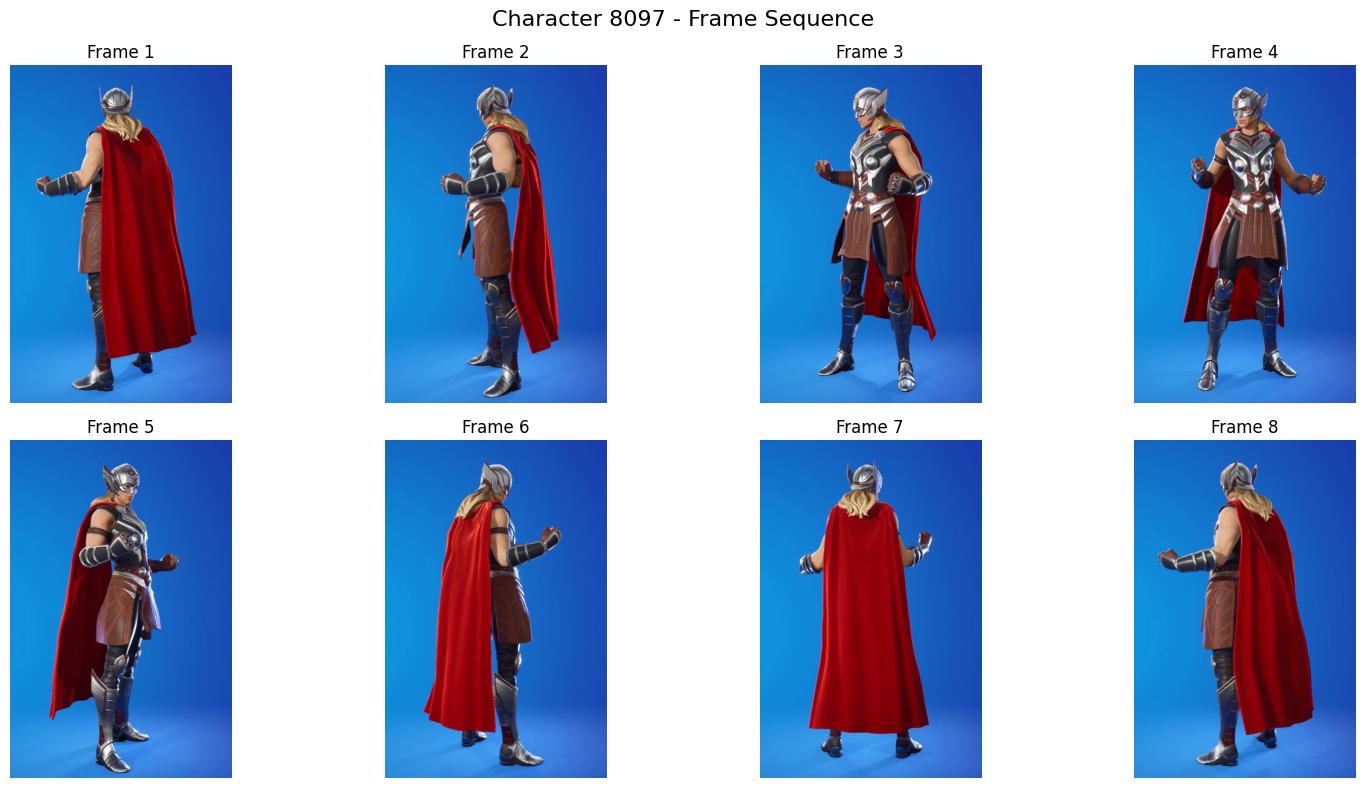

Showing 8 frames out of 8 total frames


In [53]:
# Example: Visualize frames for a specific character
# Replace 'CHARACTER_ID' with an actual character ID from your videos
# visualize_character_frames('CHARACTER_ID')

# Or visualize the first character found
if all_results:
    first_character = list(all_results.keys())[0]
    print(f"Visualizing frames for character: {first_character}")
    visualize_character_frames(first_character)